# Analyzing customer service calls
This notebook provides sample [EDSL](https://docs.expectedparrot.com/) code for conducting qualitative and quantitative analyses of transcripts. Using a set of transcripts of mock customer calls to a software company, we use EDSL to prompt an AI agent to identify the callers' names, emails, questions and requests. The code is readily editable for reviewing other textual content, giving the agent another persona, and prompting the agent to extract other information from the content provided.

EDSL is an open-source library for simulating surveys and experiments with language models. Please see our [documentation page](https://docs.expectedparrot.com/) for tips and tutorials on getting started.

## Importing data
We start by importing a dataset of transcripts. EDSL has a variety of features for working with different data types (e.g., [PDF pages](https://docs.expectedparrot.com/en/latest/scenarios.html#turning-pdf-pages-into-scenarios)). For purposes of demonstration, we use a CSV with a list of texts:

In [1]:
import pandas as pd

customer_calls = pd.read_csv("customer_calls.csv")
transcripts = customer_calls["transcript"].to_list()

# Inspect a sample
transcripts[0:2]

['"Agent: Good morning, thank you for calling Renovation Software Solutions. How can I assist you today? Customer: Hi, I\'m having trouble with the 3D rendering feature. It seems to crash every time I try to add a new room. Agent: I\'m sorry to hear that. Let me check if there are any known issues with the 3D rendering feature. Can you tell me which version of the software you\'re using? Customer: I\'m using version 5.3.2 on a Windows 10 PC. Agent: Thank you. There was a recent update that might resolve this issue. Please make sure your software is updated to the latest version. If the problem persists, we can arrange a remote support session to troubleshoot further. Could I have your name and email address to send you further instructions? Customer: Sure, it\'s Emily Davis, emily.davis@example.com. Agent: Great, I\'ll send the instructions to your email. I\'ll update the software and try again. If it still crashes, I\'ll call back. Thanks for your help. Agent: You\'re welcome. Have a 

## Constructing questions about the data
EDSL comes with a variety of question types that we can select from based on the form of the response that we want to get back from the model (multiple choice, linear scale, free text, etc.). Here we use `QuestionFreeText` to get the caller names and emails and `QuestionList` to list out any questions and requests of the callers:

In [2]:
from edsl.questions import QuestionFreeText, QuestionList

# Construct questions in the relevant question type templates
# Use a placeholder for the transcripts to be reviewed
q_name = QuestionFreeText(
    question_name = "name",
    question_text = "What is caller's name? Transcript: {{ transcript }}"
)

q_email = QuestionFreeText(
    question_name = "email",
    question_text = "What is caller's email address? Transcript: {{ transcript }}"
)

q_questions = QuestionList(
    question_name = "questions",
    question_text = "What questions does the caller have? Transcript: {{ transcript }}?"
)

q_requests = QuestionList(
    question_name = "requests",
    question_text = "What is the caller requesting? Transcript: {{ transcript }}?"
)

## Creating a survey
We combine the questions into a `Survey` in order to administer them all together:

In [3]:
from edsl import Survey

survey = Survey([q_name,
                 q_email,
                 q_questions,
                 q_requests])

## Adding the data to the questions
We create a `Scenario` object for each transcript to be reviewed:

In [4]:
from edsl import Scenario

scenarios = [Scenario({"transcript":t}) for t in transcripts]

## Designing an AI agent to answer the survey
We can create a persona for an AI `Agent` that the language model will use to answer the questions, and give it instructions on the task:

In [5]:
from edsl import Agent

agent = Agent(traits = {"persona":"Customer service agent"},
              instruction = "You are answering questions about transcripts of customer service calls.")

## Simulating responses
We generate responses by adding the scenarios and agent to the survey and calling the `run()` method:

In [6]:
results = survey.by(scenarios).by(agent).run()

This generates a dataset of `Results` that we can begin analyzing. 
EDSL comes with [built-in methods for analyzing results](https://docs.expectedparrot.com/en/latest/results.html).
For example, we can print the responses in a table:

In [7]:
results.select("name", "email", "questions", "requests").print(format="rich")

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ answer        ┃ answer                    ┃ answer                           ┃ answer                           ┃
┃ .name         ┃ .email                    ┃ .questions                       ┃ .requests                        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Emily Davis   │ emily.davis@example.com   │ ['3D rendering feature crash',   │ ['troubleshooting', '3D          │
│               │                           │ 'adding a new room', 'software   │ rendering feature crash',        │
│               │                           │ version', 'Windows 10            │ 'software update', 'remote       │
│               │                           │ compatibility', 'recent update', │ support session']                │
│               │                           │ 'remote support session',        │                                  │
│               │                           │ 'software update instructions']  │                                  │
├───────────────┼───────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│ Sarah Johnson │ sarah.johnson@example.com │ ['tutorial on budget tracking    │ ['tutorial', 'budget tracking    │
│               │                           │ feature', 'video guide',         │ feature', 'video guide',         │
│               │                           │ 'step-by-step guide', 'live      │ 'step-by-step guides', 'live     │
│               │                           │ demo']                           │ demo']                           │
├───────────────┼───────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│ Mike Thomas   │ mike.thomas@example.com   │ ['reset password', 'locked out', │ ['reset password', 'locked out', │
│               │                           │ 'email address', 'password reset │ 'password reset link']           │
│               │                           │ link', 'check spam folder']      │                                  │
├───────────────┼───────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│ Laura Miller  │ laura.miller@example.com  │ ['interested in upgrading my     │ ['upgrading subscription plan',  │
│               │                           │ subscription plan', 'options     │ 'options available', 'email      │
│               │                           │ available', 'email me the        │ comparison chart',               │
│               │                           │ comparison chart']               │ 'laura.miller@example.com',      │
│               │                           │                                  │ 'Laura Miller']                  │
├───────────────┼───────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│ Jason Lee     │ jason.lee@example.com     │ ['exporting project to PDF',     │ ['exporting project to PDF',     │
│               │                           │ 'file corruption', 'software     │ 'corrupted file', 'updating      │
│               │                           │ version', 'operating system',    │ software', 'reinstalling         │
│               │                           │ 'updating software',             │ software', 'technical support']  │
│               │                           │ 'reinstalling software',         │                                  │
│               │                           │ 'technical support', 'contact    │                                  │
│               │                           │ information']                    │                                  │
├───────────────┼───────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│ Olivia Brown  │ olivia.brown@example.com  │ ['Can mult

## Quantifying responses
We can use the lists of caller questions and requests to quantify them (how often do they appear in the calls?). We start by prompting an agent to synthesize the lists into comprehensive lists that we can use as question options for new questions:

In [8]:
caller_questions = results.select("questions").to_list(flatten=True)
len(caller_questions)

51

In [9]:
caller_requests = results.select("requests").to_list(flatten=True)
len(caller_requests)

44

In [10]:
q_condense = QuestionList(
    question_name = "condense",
    question_text = """You have reviewed a set of call transcripts and compiled a detailed
    list of {{ topic }}. Now you are being asked to condense this list into a more generalized
    but comprehensive list that can be used to quanitfy the {{ topic }} efficiently (i.e., 
    combine like items on the list). Here is the list to be condensed: {{ list }}""",
    max_list_items = 10  # Optional
)

scenarios = [Scenario({"topic":"caller questions", "list":caller_questions}),
             Scenario({"topic":"caller requests", "list":caller_requests})]

condensed_lists = q_condense.by(scenarios).run()

In [11]:
condensed_lists.select("topic", "condense").print(format="rich")

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario         ┃ answer                                                                                       ┃
┃ .topic           ┃ .condense                                                                                    ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ caller questions │ ['software issues', 'account management', 'subscription and plans', 'project management      │
│                  │ features', 'exporting and file issues', 'collaboration and team features', 'cost estimation  │
│                  │ and budgeting', 'learning resources', 'software compatibility', 'technical support and       │
│                  │ follow-up']                                                                                  │
├──────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────┤
│ caller requests  │ ['Technical Support Issues', 'Software Features and Tools', 'Account Management', 'Software  │
│                  │ Updates and Installation', 'Educational Resources', 'Subscription and Plan Management',      │
│                  │ 'Project Management Tools', 'Troubleshooting and Bug Reporting', 'Cost Estimation and        │
│                  │ Budgeting', 'Collaboration and Team Features']                                               │
└──────────────────┴──────────────────────────────────────────────────────────────────────────────────────────────┘

We can use the condensed lists as options for new questions quantifying the topics:

In [12]:
condensed_questions = condensed_lists.filter("topic == 'caller questions'").select("condense").first() 
condensed_questions

['software issues',
 'account management',
 'subscription and plans',
 'project management features',
 'exporting and file issues',
 'collaboration and team features',
 'cost estimation and budgeting',
 'learning resources',
 'software compatibility',
 'technical support and follow-up']

In [13]:
condensed_requests = condensed_lists.filter("topic == 'caller requests'").select("condense").first()
condensed_requests

['Technical Support Issues',
 'Software Features and Tools',
 'Account Management',
 'Software Updates and Installation',
 'Educational Resources',
 'Subscription and Plan Management',
 'Project Management Tools',
 'Troubleshooting and Bug Reporting',
 'Cost Estimation and Budgeting',
 'Collaboration and Team Features']

In [14]:
from edsl.questions import QuestionCheckBox

q_questions_agg = QuestionCheckBox(
    question_name = "questions_agg",
    question_text = """Review the following call transcript and then identify the topic(s)
    that the caller has questions about. Transcript: {{ transcript }}""",
    question_options = condensed_questions + ["Something else", "None of these"]
)

q_requests_agg = QuestionCheckBox(
    question_name = "requests_agg",
    question_text = """Review the following call transcript and then identify the topic(s)
    that the caller has requests about. Transcript: {{ transcript }}""",
    question_options = condensed_requests + ["Something else", "None of these"]
)

survey = Survey([q_questions_agg, q_requests_agg])

We can use the results of the initial survey as scenarios of our follow-on questions. The `to_scenario_list()` method lets us do this in a single step:

In [15]:
scenarios = results.select("name", "email", "transcript").to_scenario_list(remove_prefix=True)
scenarios[0]

Scenario({'name': 'Emily Davis', 'email': 'emily.davis@example.com', 'transcript': '"Agent: Good morning, thank you for calling Renovation Software Solutions. How can I assist you today? Customer: Hi, I\'m having trouble with the 3D rendering feature. It seems to crash every time I try to add a new room. Agent: I\'m sorry to hear that. Let me check if there are any known issues with the 3D rendering feature. Can you tell me which version of the software you\'re using? Customer: I\'m using version 5.3.2 on a Windows 10 PC. Agent: Thank you. There was a recent update that might resolve this issue. Please make sure your software is updated to the latest version. If the problem persists, we can arrange a remote support session to troubleshoot further. Could I have your name and email address to send you further instructions? Customer: Sure, it\'s Emily Davis, emily.davis@example.com. Agent: Great, I\'ll send the instructions to your email. I\'ll update the software and try again. If it still crashes, I\'ll call back. Thanks for your help. Agent: You\'re welcome. Have a great day! [Caller sounded frustrated]",'})

In [16]:
agg_results = survey.by(scenarios).by(agent).run()

In [17]:
agg_results.columns

['agent.agent_instruction',
 'agent.agent_name',
 'agent.persona',
 'answer.questions_agg',
 'answer.requests_agg',
 'comment.questions_agg_comment',
 'comment.requests_agg_comment',
 'iteration.iteration',
 'model.frequency_penalty',
 'model.logprobs',
 'model.max_tokens',
 'model.model',
 'model.presence_penalty',
 'model.temperature',
 'model.top_logprobs',
 'model.top_p',
 'prompt.questions_agg_system_prompt',
 'prompt.questions_agg_user_prompt',
 'prompt.requests_agg_system_prompt',
 'prompt.requests_agg_user_prompt',
 'question_options.questions_agg_question_options',
 'question_options.requests_agg_question_options',
 'question_text.questions_agg_question_text',
 'question_text.requests_agg_question_text',
 'question_type.questions_agg_question_type',
 'question_type.requests_agg_question_type',
 'raw_model_response.questions_agg_raw_model_response',
 'raw_model_response.requests_agg_raw_model_response',
 'scenario.edsl_class_name',
 'scenario.edsl_version',
 'scenario.email',
 

In [18]:
agg_results.select("questions_agg","requests_agg").print(format="rich")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ answer                                                 ┃ answer                                                 ┃
┃ .questions_agg                                         ┃ .requests_agg                                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ['software issues', 'technical support and follow-up'] │ ['Technical Support Issues', 'Software Updates and     │
│                                                        │ Installation', 'Troubleshooting and Bug Reporting']    │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['cost estimation and budgeting', 'learning            │ ['Software Features and Tools', 'Educational           │
│ resources']                                            │ Resources']                                            │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['account management', 'technical support and          │ ['Account Management']                                 │
│ follow-up']                                            │                                                        │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['subscription and plans']                             │ ['Subscription and Plan Management']                   │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['software issues', 'exporting and file issues',       │ ['Technical Support Issues', 'Software Updates and     │
│ 'technical support and follow-up']                     │ Installation', 'Troubleshooting and Bug Reporting']    │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['collaboration and team features']                    │ ['Software Features and Tools', 'Collaboration and     │
│                                                        │ Team Features']                                        │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['cost estimation and budgeting', 'technical support   │ ['Technical Support Issues', 'Cost Estimation and      │
│ and follow-up']                                        │ Budgeting']                                            │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['software issues', 'account management', 'technical   │ ['Technical Support Issues', 'Account Management']     │
│ support and follow-up']                                │                                                        │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['project management features']                        │ ['Software Features and Tools', 'Project Management    │
│                                                        │ Tools']                                                │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['subscription and plans']                             │ ['Software Features and Tools', 'Account Management',  │
│                                                        │ 'Subscription and Plan Management']                    │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

## Visualizations
We can turn the results into a dataframe and inspect the totals:

In [19]:
import matplotlib.pyplot as plt
import ast

In [20]:
df = agg_results.to_pandas(remove_prefix=True)

In [21]:
# Convert the string representations of lists to actual lists
df['questions_agg'] = df['questions_agg'].apply(ast.literal_eval)
df['requests_agg'] = df['requests_agg'].apply(ast.literal_eval)

# Explode the lists into individual rows
questions_exploded = df.explode('questions_agg')
requests_exploded = df.explode('requests_agg')

# Count the frequency of each item
questions_counts = questions_exploded['questions_agg'].value_counts().reset_index()
questions_counts.columns = ['Question', 'Count']

requests_counts = requests_exploded['requests_agg'].value_counts().reset_index()
requests_counts.columns = ['Request', 'Count']

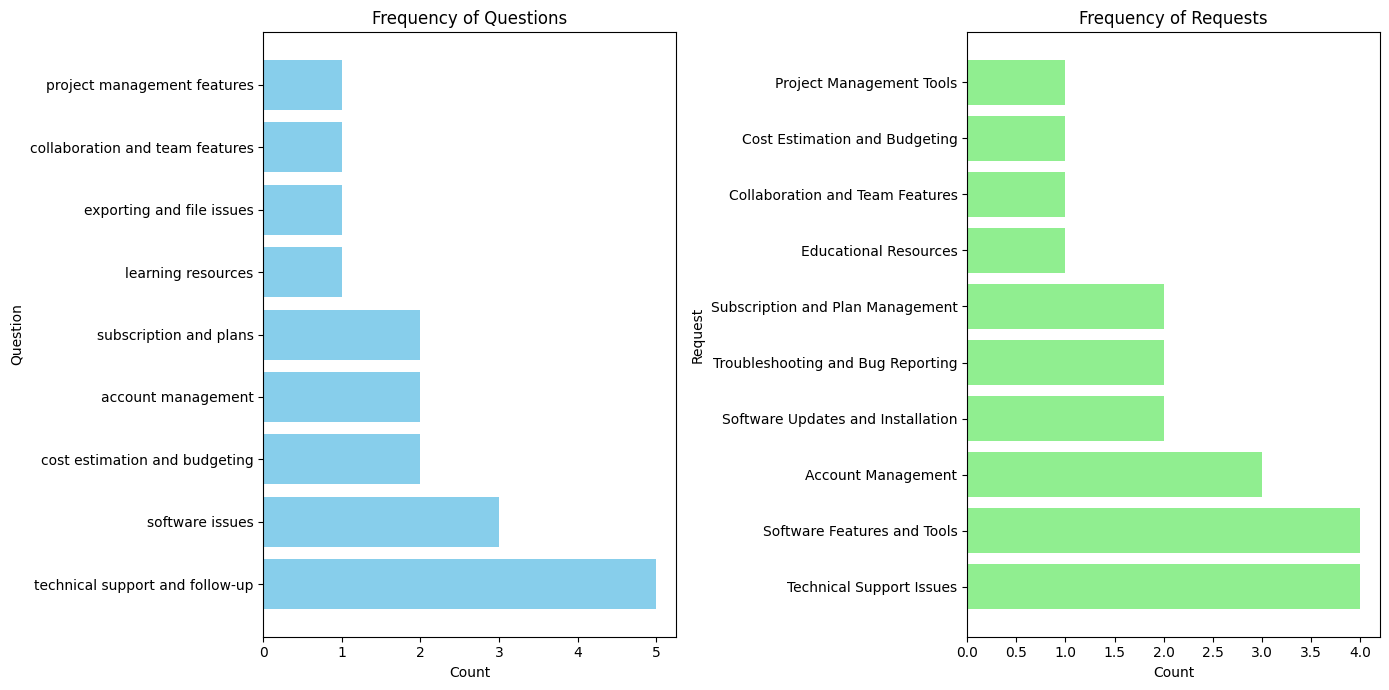

In [22]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Bar plot for questions
axes[0].barh(questions_counts['Question'], questions_counts['Count'], color='skyblue')
axes[0].set_title('Frequency of Questions')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Question')

# Bar plot for requests
axes[1].barh(requests_counts['Request'], requests_counts['Count'], color='lightgreen')
axes[1].set_title('Frequency of Requests')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Request')

plt.tight_layout()
plt.show()

In [23]:
# Display the counts
print("Questions Count Table:")
print(questions_counts)

print("\nRequests Count Table:")
print(requests_counts)

Questions Count Table:
                          Question  Count
0  technical support and follow-up      5
1                  software issues      3
2    cost estimation and budgeting      2
3               account management      2
4           subscription and plans      2
5               learning resources      1
6        exporting and file issues      1
7  collaboration and team features      1
8      project management features      1

Requests Count Table:
                             Request  Count
0           Technical Support Issues      4
1        Software Features and Tools      4
2                 Account Management      3
3  Software Updates and Installation      2
4  Troubleshooting and Bug Reporting      2
5   Subscription and Plan Management      2
6              Educational Resources      1
7    Collaboration and Team Features      1
8      Cost Estimation and Budgeting      1
9           Project Management Tools      1


## Exporting results
We can export the results as a CSV:

In [24]:
agg_results.to_csv("customer_calls_analysis.csv")

Please see our [documentation page](https://docs.expectedparrot.com/) for examples of other methods and use cases!